# **SMU Course Bidding Prediction Using CatBoost**

<h2><span style="color:red">NOTE: use at your own descretion.</span> I will not be liable for any failed bids.</h2>

### **Objective**
This notebook predicts the minimum bid required for courses in the SMU bidding system using a **CatBoost** regression model. It includes:
1. Data preparation and train-test splitting.
2. Baseline model development and evaluation.
3. Model optimization through hyperparameter tuning.
4. Handling outliers for improved performance.
5. Analysis of safety factors and confidence intervals.

We assume the columns in the CSV are:
`Term, Description, Section, Vacancy, Min Bid, Instructor, AY, Round, Window, SubjectArea, CatalogueNo, BidderCount`

Note: The logic for determining the test dataset is that we take all rows with `AY=2024` and `Term=1` as the test set, and the rest as training.

Make sure to have `catboost` installed via `pip install catboost`.

## **1. Data Preparation**

### 1.1 **Loading the Data**
- Import necessary libraries.
- Load the dataset and display its structure.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_log_error

# Load data
data = pd.read_csv('transformed_data.csv')  # Ensure this file is in your working directory
print("Data Shape:", data.shape)
display(data.head())

Data Shape: (36718, 12)


,Term,Description,Section,Vacancy,Min Bid,Instructor,AY,Round,Window,SubjectArea,CatalogueNo,BidderCount
0,2,Financial Reporting and Analysis,G3,42,25.00,GOH BENG WEE,2021,6.0,3,ACCT,224,1
1,2,Valuation,G1,42,10.09,CHENG NAM SANG,2021,6.0,3,ACCT,336,1
2,2,Valuation,G2,42,10.00,CHENG NAM SANG,2021,6.0,3,ACCT,336,2
3,2,Auditing for the Public Sector,G1,42,25.00,LIM SOO PING,2021,6.0,3,ACCT,409,1
4,2,Public Relations Writing,G1,45,10.00,YASMIN HANNAH RAMLE,2021,6.0,3,COMM,225,1


### 1.2 **Standardizing Data Types**
- Ensure proper data types for numeric and categorical columns.

In [37]:
# Ensure proper data types for all columns
def standardise_data_types(data):
    # Convert numeric columns
    data['AY'] = pd.to_numeric(data['AY'], errors='coerce')
    data['Term'] = pd.to_numeric(data['Term'], errors='coerce')
    data['Vacancy'] = pd.to_numeric(data['Vacancy'], errors='coerce')
    data['Min Bid'] = pd.to_numeric(data['Min Bid'], errors='coerce')
    data['BidderCount'] = pd.to_numeric(data['BidderCount'], errors='coerce')

    # Convert Round: fill NaN with 0 and make it integer
    data['Round'] = data['Round'].fillna(0).astype(int)

    # Convert CatalogueNo to object
    data['CatalogueNo'] = data['CatalogueNo'].astype('object')

    # Ensure object columns are properly typed
    object_cols = ['Description', 'Section', 'Instructor', 'SubjectArea']
    for col in object_cols:
        data[col] = data[col].astype('object')

    return data

# Apply standardisation
data = standardise_data_types(data)

### 1.3 **Train-Test Split**
- Split the dataset into training (AY < 2024) and testing (AY = 2024, Term = 1).

In [38]:
# Define test set as AY=2024 and Term=1
test_mask = (data['AY'] == 2024) & (data['Term'] == 1)
test_data = data[test_mask].copy()
train_data = data[~test_mask].copy()

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (31379, 12)
Test shape: (5339, 12)


## **2. Baseline Model Development**

### 2.1 **Feature Selection**
- Define features, target, and categorical variables.

In [39]:
target = 'Min Bid'
features = ['Term', 'Description', 'Section', 'Vacancy', 'Instructor', 'AY', 'Round', 'Window', 'SubjectArea', 'CatalogueNo', 'BidderCount']

# Assume these are categorical:
cat_features = ['Description', 'Section', 'Instructor', 'SubjectArea', 'CatalogueNo']

X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

### 2.2 **Training the Baseline Model**
- Train a CatBoost model with default parameters.

In [40]:
model = CatBoostRegressor(cat_features=cat_features, verbose=False)
model.fit(X_train, y_train)

### 2.3 **Predictions and Metrics**
- Compute MSLE and TP rate.

**MSLE (Mean Squared Log Error)**
- Measures relative error, penalising underestimations.

**TP Rate**
- The fraction of predictions where `predicted_min_bid >= actual_min_bid`.

In [67]:
# Get predictions
y_pred = model.predict(X_test)

# Compute MSLE
msle_value = mean_squared_log_error(y_test, y_pred)

# Compute TP Rate
pred_binary = (y_pred >= y_test).astype(int)
tp_rate = pred_binary.mean()

print("MSLE:", msle_value)
print("TP Rate:", tp_rate)

MSLE: 0.26184950282824365
TP Rate: 0.5487919085971156


### 2.4 **Confidence Interval for a Prediction**
- Estimate a 95% confidence interval using bootstrapping.

We will:
1. Take a single new data point.
2. Perform bootstrap by training multiple models on resampled data.
3. Predict on the single instance each time.
4. Compute mean and std of these predictions.
5. Derive a 95% CI (mean ± 1.96*std).

In [42]:
# Example single instance
# Adjust these values as needed:
new_data = pd.DataFrame({
    'Term': [1],
    'Description': ["Financial Analytics"],
    'Section': ["G1"],
    'Vacancy': [45],
    'Instructor': ["RANDALL EUGENE DURAN"],
    'AY': [2024],
    'Round': [1],
    'Window': [1],
    'SubjectArea': ["IS"],
    'CatalogueNo': ["453"],
    'BidderCount': [35]
})

# Predict with the main model
single_pred = model.predict(new_data)
print("Predicted Min Bid:", single_pred[0])

Predicted Min Bid: 38.63814864228507


### Bootstrap-based Confidence Interval
We'll retrain the model multiple times on bootstrap samples of the training data and predict each time.

In [43]:
n_bootstrap = 10
bootstrap_preds = []

for i in range(n_bootstrap):
    # Sample training data with replacement
    sample = train_data.sample(frac=1.0, replace=True)
    X_sample = sample[features]
    y_sample = sample[target]
    
    temp_model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.1,
        depth=6,
        cat_features=cat_features,
        verbose=False
    )
    temp_model.fit(X_sample, y_sample)
    
    # Predict on the single new instance
    single_boot_pred = temp_model.predict(new_data)
    bootstrap_preds.append(single_boot_pred[0])

bootstrap_preds = np.array(bootstrap_preds)
mean_pred = bootstrap_preds.mean()
std_pred = bootstrap_preds.std()

# Approximate 95% CI assuming normal distribution
ci_lower = mean_pred - 1.96 * std_pred
ci_upper = mean_pred + 1.96 * std_pred

print(f"Single Instance Prediction: {mean_pred:.2f}")
print(f"Approx. 95% Confidence Interval: [{ci_lower:.2f}, {ci_upper:.2f}]")

Single Instance Prediction: 35.95
Approx. 95% Confidence Interval: [25.11, 46.78]


## **3. Model Optimization**

### 3.1 **Hyperparameter Tuning**
- Perform grid search to optimize the CatBoost model.

## Improving TPR

If the TPR is low, it means we often under-predict the min bid. To increase TPR:
- **Hyperparameter Tuning:** Experiment with learning rate, depth, or iterations to improve model accuracy.
- **Safety factor calculation:** Consider a safety factor on the prediction.

In [ ]:
# Hyperparameter Tuning with Plot
param_grid = {
    'iterations': [200, 500, 1000],
    'learning_rate': [0.1, 0.05, 0.01],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5],
    'bagging_temperature': [0.5, 1, 2],
    'random_strength': [1, 2],
}

model = CatBoostRegressor(task_type="GPU", devices='0', eval_metric="RMSE", logging_level="Silent",cat_features=cat_features) #NOTE: RMSE used instead of MSLE because CatBoost doesn't support MSLE

grid_search_result = model.grid_search(
    param_grid,
    X=X_train,
    y=y_train,
    cv=5,                       # 3-fold cross-validation
    partition_random_seed=42,   # Seed for reproducibility
    shuffle=True,               # Shuffle data before splitting
    stratified=False,           # Not stratified since it's regression
    verbose=True,               # Show updates during search
    plot=True                   # Enable plot for visualisation
)

print("Best Parameters:", grid_search_result['params'])
print("Cross-Validation Results:")
print(grid_search_result['cv_results'])

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

### 3.2 **Evaluating the Tuned Model**
- Retrain and evaluate the optimized model.

In [44]:
tuned_model = CatBoostRegressor(
    bagging_temperature= 1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

tuned_model.fit(X_train, y_train)

In [45]:
y_pred_tuned = tuned_model.predict(X_test) 
msle_tuned = mean_squared_log_error(y_test, y_pred_tuned) 
tp_rate_tuned = (y_pred_tuned >= y_test).astype(int).mean() 
print("Tuned MSLE:", msle_tuned) 
print("Tuned TP Rate:", tp_rate_tuned) 

Tuned MSLE: 0.2778804665898058
Tuned TP Rate: 0.5424236748454767


## **4. Handling Outliers** 
### 4.1 **Removing Outliers** 
- Identify and remove outliers using the IQR method. 

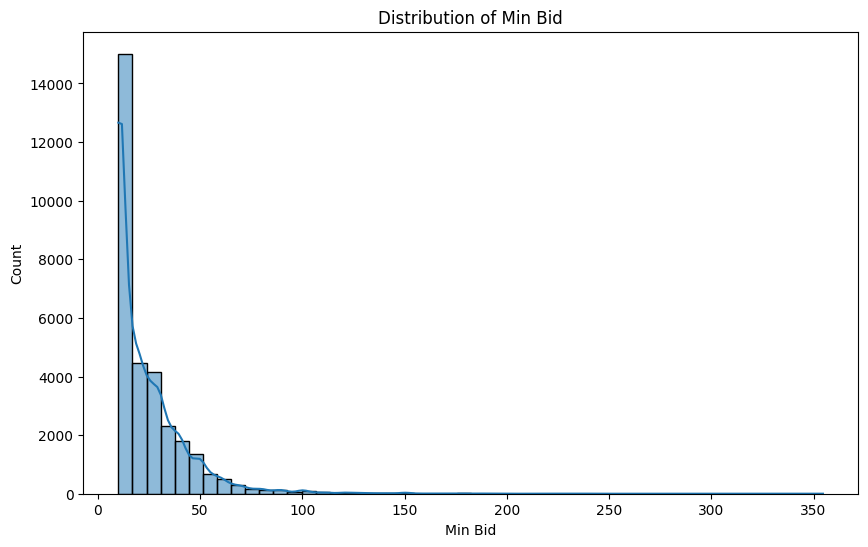

IQR Lower Bound: -19.705000000000005, Upper Bound: 60.255
Original Training Data Shape: (31379, 12)
Cleaned Training Data Shape: (29970, 12)


In [46]:
# Plot Min Bid Distribution to Understand Outliers
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Min Bid'], bins=50, kde=True)
plt.title('Distribution of Min Bid')
plt.show()

# Compute IQR for Outlier Removal
q1 = train_data['Min Bid'].quantile(0.25)
q3 = train_data['Min Bid'].quantile(0.75)
iqr = q3 - q1

# Define Lower and Upper Boundaries
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"IQR Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Filter Outliers
cleaned_train_data = train_data[(train_data['Min Bid'] >= lower_bound) & (train_data['Min Bid'] <= upper_bound)]

print("Original Training Data Shape:", train_data.shape)
print("Cleaned Training Data Shape:", cleaned_train_data.shape)

In [47]:
# Define new training set
X_train_cleaned = cleaned_train_data[features]
y_train_cleaned = cleaned_train_data[target]

### 4.2 **Retraining with Cleaned Data** 
- Retrain the model and compare performance. 

In [48]:
# Train CatBoost Regressor with Cleaned Data
model_cleaned = CatBoostRegressor(
    bagging_temperature=1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

model_cleaned.fit(X_train_cleaned, y_train_cleaned)

In [49]:
# Predictions with Cleaned Model
y_pred_cleaned = model_cleaned.predict(X_test)

# Compute Metrics for Cleaned Model
msle_cleaned = mean_squared_log_error(y_test, y_pred_cleaned)
tp_rate_cleaned = (y_pred_cleaned >= y_test).astype(int).mean()

print("Cleaned Model MSLE:", msle_cleaned)
print("Cleaned Model TP Rate:", tp_rate_cleaned)

# Compare with Original Model Metrics
print("Original Model MSLE:", msle_value)
print("Original Model TP Rate:", tp_rate)

Cleaned Model MSLE: 0.2324833406606893
Cleaned Model TP Rate: 0.5178872448023975
Original Model MSLE: 0.26184950282824365
Original Model TP Rate: 0.5487919085971156


## **5 Including Historical Average Min Bid Prices** 
### **5.1 Adding a "Historical Mean Minimum Bid" Column** 
To further enhance our model, we include a new feature: the **historical mean minimum bid price** for each combination of `Description` and `Instructor`. This column is computed by: 
1. Aggregating all previous bidding rounds to calculate the average minimum bid grouped by `Description` and `Instructor`. 
2. Ensuring that the current row’s bidding round is excluded from the aggregation to prevent data leakage. 

In [62]:
# Function to calculate historical mean minimum bid excluding current row
def add_historical_mean_min_bid(data, group_cols, target_col):
    data['Historical Mean Min Bid'] = (
        data.groupby(group_cols)[target_col]
        .transform(lambda x: x.expanding().mean().shift(1))
    )
    return data

# Apply the function to compute the column
train_data = add_historical_mean_min_bid(train_data, group_cols=['Description', 'Instructor'], target_col='Min Bid')
test_data['Historical Mean Min Bid'] = test_data['Description'].map(
    train_data.groupby(['Description', 'Instructor'])['Min Bid'].mean()
)

# Display a sample of the updated data
display(train_data[['Description', 'Instructor', 'Min Bid', 'Historical Mean Min Bid']].head(10))

,Description,Instructor,Min Bid,Historical Mean Min Bid
0,Financial Reporting and Analysis,GOH BENG WEE,25.00,NaN
1,Valuation,CHENG NAM SANG,10.09,NaN
2,Valuation,CHENG NAM SANG,10.00,10.09
3,Auditing for the Public Sector,LIM SOO PING,25.00,NaN
4,Public Relations Writing,YASMIN HANNAH RAMLE,10.00,NaN
5,Designing Communication for Behavioural Change,SUNGJONG ROH,10.00,NaN
6,Management Communication,CHAN BOH YEE,35.00,NaN
7,Japanese,"AKIKO ITO, AKIKO ITO",26.44,NaN
8,"Business, Government and Society",CHAN KAY MIN,25.00,NaN
9,Spreadsheet Modeling and Analytics,KARTHIKEYAN KANNAN,40.00,NaN


#### **5.2 Incorporating the New Feature into the Model** 
- Add `Historical Mean Min Bid` to the feature set. 
- Retrain the model using the updated dataset with this additional feature. 

In [64]:
# Ensure features is a list
features = list(features)

# Add the new feature to the list
features.append('Historical Mean Min Bid')

# Retrain the model with the new feature
X_train = train_data[features]
X_test = test_data[features]

model_with_history = CatBoostRegressor(
    bagging_temperature=1,
    random_strength=1,
    depth=10,
    learning_rate=0.1,
    l2_leaf_reg=5,
    iterations=1000,
    cat_features=cat_features,
    verbose=False
)

model_with_history.fit(X_train, y_train)

#### **5.3 Evaluating the Model with Historical Feature** 
Evaluate the model's performance after adding the new feature to determine its impact. 

In [65]:
# Predictions and metrics
y_pred_with_history = model_with_history.predict(X_test)

# MSLE and TP Rate
msle_with_history = mean_squared_log_error(y_test, y_pred_with_history)
tp_rate_with_history = (y_pred_with_history >= y_test).astype(int).mean()

print("Model with Historical Mean MSLE:", msle_with_history)
print("Model with Historical Mean TP Rate:", tp_rate_with_history)

Model with Historical Mean MSLE: 0.29108436374756397
Model with Historical Mean TP Rate: 0.448023974527065


#### **5.4 Comparing Performance** 
Compare the performance of the original and updated models to assess the benefit of including the historical mean minimum bid. 

In [68]:
print("Comparison of Models:")
print(f"Baseline Model MSLE: {msle_value}, TP Rate: {tp_rate}")
print(f"Cleaned Model MSLE: {msle_cleaned}, TP Rate: {tp_rate_cleaned}")
print(f"Model with Historical Feature MSLE: {msle_with_history}, TP Rate: {tp_rate_with_history}")

Comparison of Models:
Baseline Model MSLE: 0.26184950282824365, TP Rate: 0.5487919085971156
Cleaned Model MSLE: 0.2324833406606893, TP Rate: 0.5178872448023975
Model with Historical Feature MSLE: 0.29108436374756397, TP Rate: 0.448023974527065


## **6. Safety Factors and Analysis** 
### 6.1 **Adjusting for Safety Factors** 
- Experiment with safety factors to improve TP rate. 

MSLE: 0.2324833406606893
Initial TPR (no safety factor): 0.5178872448023975


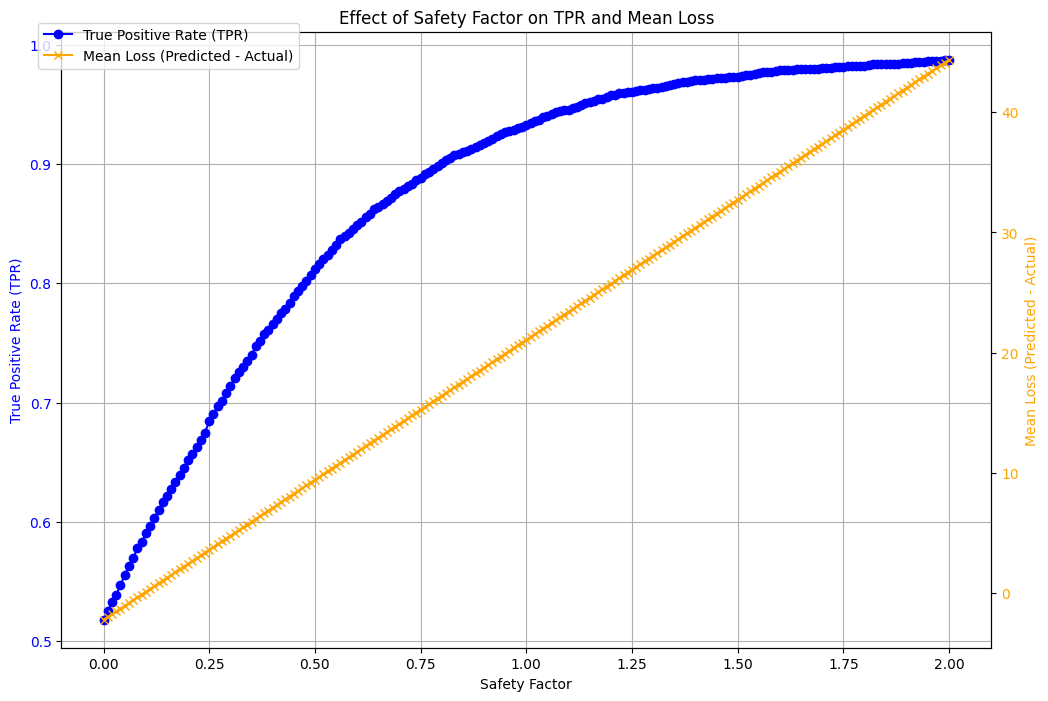

In [76]:
# Initialize lists to store results
safety_factors = np.arange(0.00, 2.01, 0.01)
tpr_values = []
loss_values = []

# Original predictions
y_pred = model_cleaned.predict(X_test)

# Compute MSLE (unchanged)
msle_value = mean_squared_log_error(y_test, y_pred)

# Loop through safety factors
for sf in safety_factors:
    # Apply safety factor to predictions
    adjusted_pred = y_pred * (1 + sf)

    # Compute TP Rate
    pred_binary = (adjusted_pred >= y_test).astype(int)
    tp_rate = pred_binary.mean()

    # Compute Mean Loss (average difference between predicted and actual)
    mean_loss = np.mean(adjusted_pred - y_test)

    # Store TPR and Loss
    tpr_values.append(tp_rate)
    loss_values.append(mean_loss)

# Print MSLE and initial TPR (without safety factor)
print("MSLE:", msle_value)
print("Initial TPR (no safety factor):", tpr_values[0])

# Plot TPR and Mean Loss with Dual Y-Axes
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plot TPR on the left y-axis
ax1.plot(safety_factors, tpr_values, marker='o', color='blue', label='True Positive Rate (TPR)')
ax1.set_xlabel('Safety Factor')
ax1.set_ylabel('True Positive Rate (TPR)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Effect of Safety Factor on TPR and Mean Loss')
ax1.grid(True)

# Plot Mean Loss on the right y-axis
ax2 = ax1.twinx()
ax2.plot(safety_factors, loss_values, marker='x', color='orange', label='Mean Loss (Predicted - Actual)')
ax2.set_ylabel('Mean Loss (Predicted - Actual)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a legend for clarity
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
plt.show()

### 6.2 **Tree plotting** 
- Visualise top 10 levels variables for decision making

In [77]:
pool = Pool(X_train, y_train, cat_features=cat_features, feature_names=list(X_train.columns))
tuned_model.plot_tree(tree_idx=0, pool=pool)

### 6.3 **Feature Importance** 
- Top 3 features contributing to prediction

        Feature  Importance
4    Instructor   13.498704
9   CatalogueNo   12.849593
1   Description   12.100502
8   SubjectArea   11.629846
6         Round   10.893801
10  BidderCount   10.721669
2       Section    9.604623
5            AY    6.557268
7        Window    5.003073
3       Vacancy    3.953986


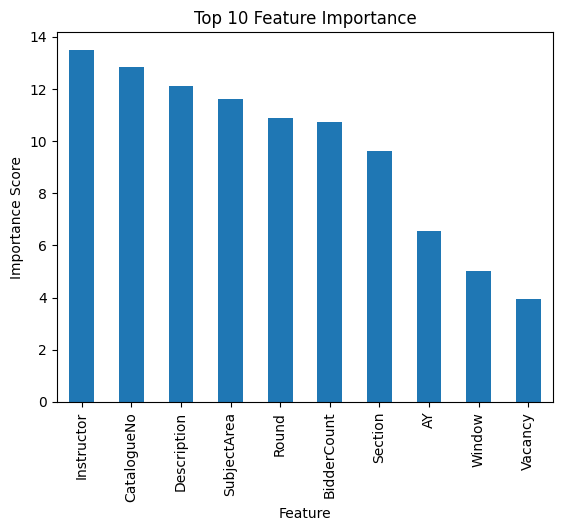

In [78]:
# Use model's internal feature names
features = tuned_model.feature_names_

# Get feature importance scores
feature_importance = tuned_model.get_feature_importance(type='FeatureImportance')

# Create a DataFrame for better readability
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 3 features
top_features = importance_df.head(10)
print(top_features)

# Visualize feature importance
top_features.plot(kind='bar', x='Feature', y='Importance', legend=False, title="Top 10 Feature Importance")
plt.ylabel("Importance Score")
plt.show()

### 6.4 Error plotting

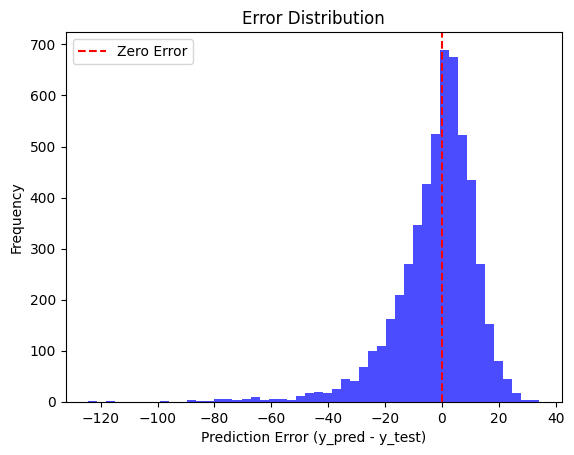

Mean Error: -2.1938554548481917
Median Error: 0.44756373916488457
Fraction of Predictions Below Actual: 48.21%


In [81]:
errors = y_pred - y_test

plt.hist(errors, bins=50, alpha=0.7, color='blue')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.xlabel('Prediction Error (y_pred - y_test)')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.legend()
plt.show()

mean_error = np.mean(errors)
median_error = np.median(errors)
below_zero = np.mean(errors < 0)  # Fraction of under-predictions
print(f"Mean Error: {mean_error}")
print(f"Median Error: {median_error}")
print(f"Fraction of Predictions Below Actual: {below_zero:.2%}")

## **6. Conclusion** 

**What was done**

In this notebook, we:
1. Created a quick catboost model
2. Fine-tuned using:
    - Grid-search CV
    - Cleaning outliers
    - Adding historical average min bid price column
3. Evalauted trade offs between Mean Loss and TPR. Found feature importance.

**What can be concluded**
1. Outliers doesn't affect boostign models that much.
2. Adding historical averages like bid prices also doesn't add much value.
3. Hyperparameter tuning not impactful as starting model wasn't very good already.
4. As expected top determinants of prices are instructor (e.g. RANDALL EUGENE DURAN), course catalogue number (e.g. 453) and description (e.g. Financial Analytics).

**What to do next**
1. Perhaps we can capture more meaningful relationships through embedding of categorical variables. Create a DNN with embeddings.
2. Hard to predict prices as human nature unpredictable. If ML model predicted a given price, likelihood is for people to add extra on top of predicted price to secure.